# Creating a Lower Limb Panoramic X-ray
Measurement of knee alignment is useful for diagnosis of arthritic conditions and for planning and evaluation of surgical interventions. Alignment is measured by the hip-knee-ankle (HKA) angle in standing, load bearing, x-ray images. The angle is defined by the femoral and tibial mechanical axes. The femoral axis is defined by the center of the femur head and the mid condylar point. The tibial axis is defined by the center of the tibial plateau to the center of the tibial plafond.

For additional information see:

T. D. Cooke et al., "Frontal plane knee alignment: a call for standardized measurement", J Rheumatol. 2007.
A. F. Kamath et al., "What is Varus or Valgus Knee Alignment?: A Call for a Uniform Radiographic Classification", Clin Orthop Relat Res. 2010.
This notebook is based in part on the work described in:

Y. K. Ben-Zikri et al., "A marker-free registration method for standing X-ray panorama reconstruction for hip-knee-ankle axis deformity assessment", Computer Methods in Biomechanics and Biomedical Engineering: Imaging & Visualization, DOI:10.1080/21681163.2018.1537859.

In [1]:
import SimpleITK as sitk
import numpy as np
import os.path
import copy

%matplotlib inline
import matplotlib.pyplot as plt

## Loading Data

(-0.5, 869.5, 1059.5, -0.5)

<Figure size 432x288 with 0 Axes>

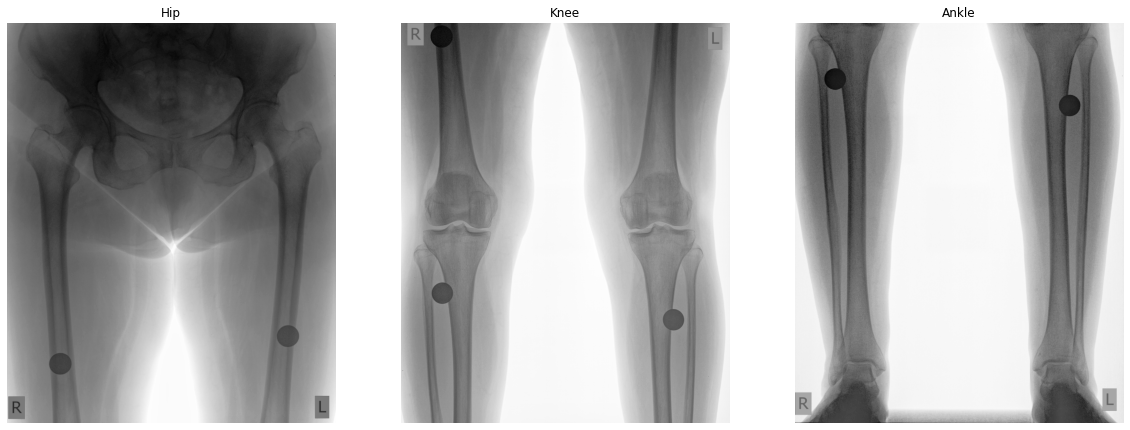

In [3]:
# Fetch all of the data associated with this example.
hip_image = sitk.ReadImage('data/hip.mha')
knee_image = sitk.ReadImage('data/knee.mha')
ankle_image = sitk.ReadImage('data/ankle.mha')

#gui.multi_image_display2D([hip_image, knee_image, ankle_image], figure_size=(10, 4));
plt.figure()
f, axarr = plt.subplots(1,3,figsize=(20,20)) 

axarr[0].imshow(sitk.GetArrayViewFromImage(hip_image),cmap=plt.cm.Greys_r)
axarr[0].set_title("Hip")
axarr[0].axis('off')
axarr[1].imshow(sitk.GetArrayViewFromImage(knee_image),cmap=plt.cm.Greys_r)
axarr[1].set_title("Knee")
axarr[1].axis('off')
axarr[2].imshow(sitk.GetArrayViewFromImage(ankle_image),cmap=plt.cm.Greys_r)
axarr[2].set_title("Ankle")
axarr[2].axis('off')

## Getting to know your data
As our goal is to register the images we need to identify an appropriate similarity metric and transformation type.

## Similarity metric
Given that we are using the same device to acquire multiple partially overlapping images, we would expect that the intensities for the same anatomical structures are the same in all images. We start by visually inspecting the images displayed above. If you hover the cursor over the images you will see the intensity value on the bottom right.

We next plot the histogram for one of the images.

Text(0.5, 1.0, 'Ankle')

<Figure size 432x288 with 0 Axes>

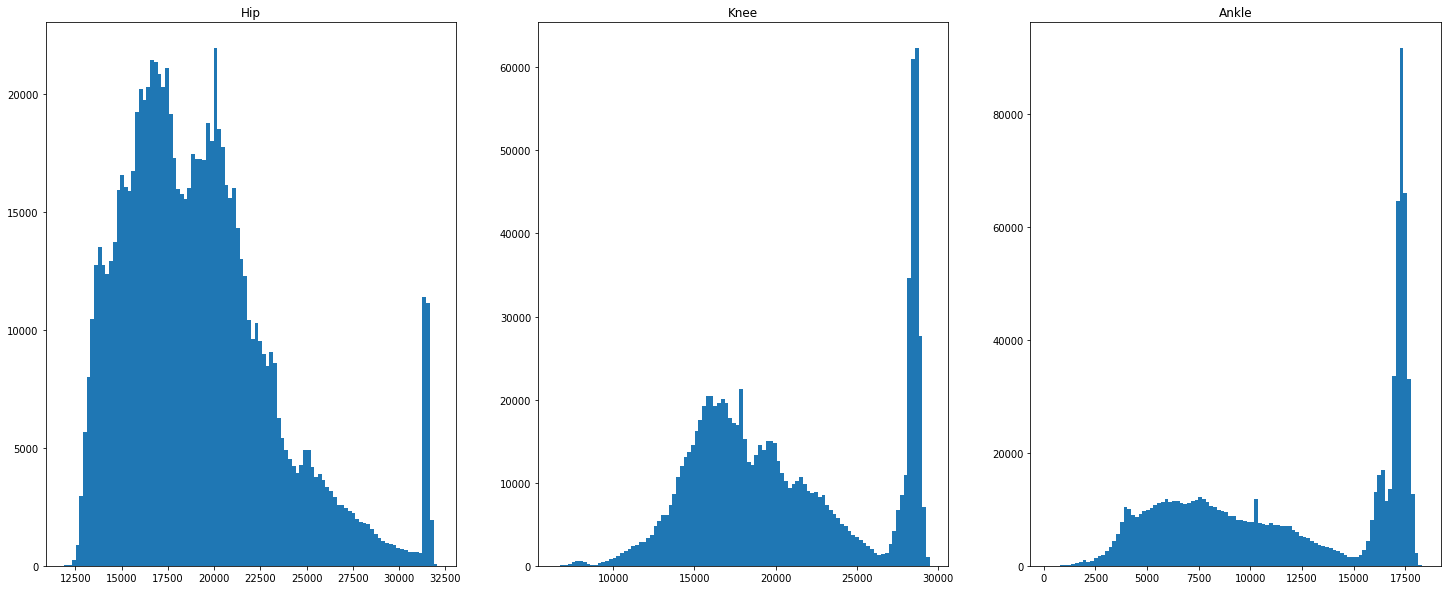

In [4]:
intensity_profile_hip = hip_image
intensity_profile_knee = knee_image
intensity_profile_ankle = ankle_image

plt.figure()
f, axarr = plt.subplots(1,3,figsize=(25,10))

axarr[0].hist(sitk.GetArrayViewFromImage(intensity_profile_hip).flatten(), bins=100)
axarr[0].set_title("Hip")
axarr[1].hist(sitk.GetArrayViewFromImage(intensity_profile_knee).flatten(), bins=100)
axarr[1].set_title("Knee")
axarr[2].hist(sitk.GetArrayViewFromImage(intensity_profile_ankle).flatten(), bins=100)
axarr[2].set_title("Ankle")

Notice that the image has a high dynamic range which is mapped to a low dynamic range when displayed, so we cannot observe all underlying intensity variations. Ideally intensity variations in x-ray images only occur when there are variations in the imaged object. In practice, we can observe non uniform intensities due to the structure of the x-ray device (e.g. absorption of photons by the x-ray anode,known as the heel effect).

## Transformation type
In general, the x-ray machine is modeled as a pinhole camera, with our images acquired using a fronto-parallel setup and the camera undergoing translation. This simplifies the general model from a homography transformation between images to a planar translation. For a detailed derivation see:

Z. Yaniv, L. Joskowicz, "Long Bone Panoramas from Fluoroscopic X-ray Images", IEEE Trans Med Imaging. 2004.
While our transformation type is translation, looking at multiple triplets of images we observed that the size of overlapping regions, expected translations, has significant variability. Consequentially, we will use a heuristic exploration-exploitation approach to improve the robustness of our registration approach.

Registration - Exploration Step
As image overlap has considerable variation we will use the ExhaustiveOptimizer to obtain several starting points, our exploration step. We then start a standard registration using these initial transformation estimates, our exploitation step. Finally we select the best transformation from the exploitation step.

In [5]:
class Evaluate2DTranslationCorrelation:
    """
    Class for evaluating the correlation value for a given set of
    2D translations between two images. The general relationship between
    the fixed and moving images is assumed (fixed is "below" the moving).
    We use the Exhaustive optimizer to sample the possible set of translations
    and an observer to tabulate the results.

    In this class we abuse the Python dictionary by using a float
    value as the key. This is a unique situation in which the floating
    values are fixed (not resulting from various computations) so that we
    can compare them for exact equality. This means they have the
    same hash value in the dictionary.
    """

    def __init__(
        self,
        metric_sampling_percentage,
        min_row_overlap,
        max_row_overlap,
        column_overlap,
        dx_step_num,
        dy_step_num,
    ):
        """
        Args:
            metric_sampling_percentage: Percentage of samples to use
                                        when computing correlation.
            min_row_overlap: Minimal number of rows that overlap between
                             the two images.
            max_row_overlap: Maximal number of rows that overlap between
                             the two images.
            column_overlap: Maximal translation in columns either in positive
                            and negative direction.
            dx_step_num: Number of samples in parameter space for translation along
                         the x axis is 2*dx_step_num+1.
            dy_step_num: Number of samples in parameter space for translation along
                         the y axis is 2*dy_step_num+1.

        """
        self._registration_values_dict = {}
        self.X = None
        self.Y = None
        self.C = None
        self._metric_sampling_percentage = metric_sampling_percentage
        self._min_row_overlap = min_row_overlap
        self._max_row_overlap = max_row_overlap
        self._column_overlap = column_overlap
        self._dx_step_num = dx_step_num
        self._dy_step_num = dy_step_num

    def _start_observer(self):
        self._registration_values_dict = {}
        self.X = None
        self.Y = None
        self.C = None

    def _iteration_observer(self, registration_method):
        x, y = registration_method.GetOptimizerPosition()
        if y in self._registration_values_dict.keys():
            self._registration_values_dict[y].append(
                (x, registration_method.GetMetricValue())
            )
        else:
            self._registration_values_dict[y] = [
                (x, registration_method.GetMetricValue())
            ]

    def evaluate(self, fixed_image, moving_image):
        """
        Assume the fixed image is lower than the moving image (e.g. fixed=knee, moving=hip).
        The transformations map points in the fixed_image to the moving_image.
        Args:
            fixed_image: Image to use as fixed image in the registration.
            moving_image: Image to use as moving image in the registration.
        """
        minimal_overlap = np.array(
            moving_image.TransformContinuousIndexToPhysicalPoint(
                (
                    -self._column_overlap,
                    moving_image.GetHeight() - self._min_row_overlap,
                )
            )
        ) - np.array(fixed_image.GetOrigin())
        maximal_overlap = np.array(
            moving_image.TransformContinuousIndexToPhysicalPoint(
                (self._column_overlap, moving_image.GetHeight() - self._max_row_overlap)
            )
        ) - np.array(fixed_image.GetOrigin())
        transform = sitk.TranslationTransform(
            2,
            (
                (maximal_overlap[0] + minimal_overlap[0]) / 2.0,
                (maximal_overlap[1] + minimal_overlap[1]) / 2.0,
            ),
        )

        # Total number of evaluations, translations along the y axis in both directions around the initial
        # value is 2*dy_step_num+1.
        dy_step_length = (maximal_overlap[1] - minimal_overlap[1]) / (
            2 * self._dy_step_num
        )
        dx_step_length = (maximal_overlap[0] - minimal_overlap[0]) / (
            2 * self._dx_step_num
        )
        step_length = dx_step_length
        parameter_scales = [1, dy_step_length / dx_step_length]

        registration_method = sitk.ImageRegistrationMethod()
        registration_method.SetMetricAsCorrelation()
        registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
        registration_method.SetMetricSamplingPercentage(
            self._metric_sampling_percentage
        )
        registration_method.SetInitialTransform(transform, inPlace=True)
        registration_method.SetOptimizerAsExhaustive(
            numberOfSteps=[self._dx_step_num, self._dy_step_num], stepLength=step_length
        )
        registration_method.SetOptimizerScales(parameter_scales)

        registration_method.AddCommand(
            sitk.sitkIterationEvent,
            lambda: self._iteration_observer(registration_method),
        )
        registration_method.AddCommand(sitk.sitkStartEvent, self._start_observer)
        registration_method.Execute(fixed_image, moving_image)

        # Convert the data obtained by the observer to three numpy arrays X,Y,C
        x_lists = []
        val_lists = []
        for k in self._registration_values_dict.keys():
            x_list, val_list = zip(*(sorted(self._registration_values_dict[k])))
            x_lists.append(x_list)
            val_lists.append(val_list)

        self.X = np.array(x_lists)
        self.C = np.array(val_lists)
        self.Y = np.array(
            [
                list(self._registration_values_dict.keys()),
            ]
            * self.X.shape[1]
        ).transpose()

    def get_raw_data(self):
        """
        Get the raw data, the translations and corresponding correlation values.
        Returns:
            A tuple of three numpy arrays (X,Y,C) where (X[i], Y[i]) are the translation
            and C[i] is the correlation value for that translation.
        """
        return (np.copy(self.X), np.copy(self.Y), np.copy(self.C))

    def get_candidates(self, num_candidates, correlation_threshold, nms_radius=2):
        """
        Get the best (most correlated, minimal correlation value) transformations
        from the sample set.
        Args:
            num_candidates: Maximal number of candidates to return.
            correlation_threshold: Minimal correlation value required for returning
                                   a candidate.
            nms_radius: Non-Minima (the optimizer is negating the correlation) suppression
                        region around the local minimum.
        Returns:
            List of tuples containing (transform, correlation). The order of the transformations
            in the list is based on the correlation value (best correlation is entry zero).
        """
        candidates = []
        _C = np.copy(self.C)
        done = num_candidates - len(candidates) <= 0
        while not done:
            min_index = np.unravel_index(_C.argmin(), _C.shape)
            if -_C[min_index] < correlation_threshold:
                done = True
            else:
                candidates.append(
                    (
                        sitk.TranslationTransform(
                            2, (self.X[min_index], self.Y[min_index])
                        ),
                        self.C[min_index],
                    )
                )
                # None-minima suppression in the region around our minimum
                start_nms = np.maximum(
                    np.array(min_index) - nms_radius, np.array([0, 0])
                )
                # for the end coordinate we add nms_radius+1 because the slicing operator _C[],
                # excludes the end
                end_nms = np.minimum(
                    np.array(min_index) + nms_radius + 1, np.array(_C.shape)
                )
                _C[start_nms[0] : end_nms[0], start_nms[1] : end_nms[1]] = 0
                done = num_candidates - len(candidates) <= 0
        return candidates


def create_images_in_shared_coordinate_system(image_transform_list):
    """
    Resample a set of images onto the same region in space (the bounding)
    box of all images.
    Args:
        image_transform_list: A list of tuples each containing a transformation and an image. The transformations map the
                              images to a shared coordinate system.
    Returns:
        list of images: All images are resampled into the same coordinate system and the bounding box of all images is
                        used to define the new image extent onto which the originals are resampled. The background value
                        for the resampled images is set to 0.
    """
    pnt_list = []
    for image, transform in image_transform_list:
        pnt_list.append(transform.TransformPoint(image.GetOrigin()))
        pnt_list.append(
            transform.TransformPoint(
                image.TransformIndexToPhysicalPoint(
                    (image.GetWidth() - 1, image.GetHeight() - 1)
                )
            )
        )

    max_coordinates = np.max(pnt_list, axis=0)
    min_coordinates = np.min(pnt_list, axis=0)

    # We assume the spacing for all original images is the same and we keep it.
    output_spacing = image_transform_list[0][0].GetSpacing()
    # We assume the pixel type for all images is the same and we keep it.
    output_pixelID = image_transform_list[0][0].GetPixelID()
    # We assume the direction for all images is the same and we keep it.
    output_direction = image_transform_list[0][0].GetDirection()
    output_width = int(
        np.round((max_coordinates[0] - min_coordinates[0]) / output_spacing[0])
    )
    output_height = int(
        np.round((max_coordinates[1] - min_coordinates[1]) / output_spacing[1])
    )
    output_origin = (min_coordinates[0], min_coordinates[1])

    images_in_shared_coordinate_system = []
    for image, transform in image_transform_list:
        images_in_shared_coordinate_system.append(
            sitk.Resample(
                image,
                (output_width, output_height),
                transform.GetInverse(),
                sitk.sitkLinear,
                output_origin,
                output_spacing,
                output_direction,
                0.0,
                output_pixelID,
            )
        )
    return images_in_shared_coordinate_system


def composite_images_alpha_blending(images_in_shared_coordinate_system, alpha=0.5):
    """
    Composite a list of images sharing the same extent (size, origin, spacing, direction cosine).
    Args:
        images_in_shared_coordinate_system: A list of images sharing the same meta-information (origin, size, spacing, direction cosine).
        We assume zero denotes background.
    Returns:
        SimpleITK image with pixel type sitkFloat32: alpha blending of the images.

    """
    # Composite all of the images using alpha blending where there is overlap between two images, otherwise
    # just paste the image values into the composite image. We assume that at most two images overlap.
    composite_image = sitk.Cast(images_in_shared_coordinate_system[0], sitk.sitkFloat32)
    for img in images_in_shared_coordinate_system[1:]:
        current_image = sitk.Cast(img, sitk.sitkFloat32)
        mask1 = sitk.Cast(composite_image != 0, sitk.sitkFloat32)
        mask2 = sitk.Cast(current_image != 0, sitk.sitkFloat32)
        intersection_mask = mask1 * mask2
        composite_image = (
            alpha * intersection_mask * composite_image
            + (1 - alpha) * intersection_mask * current_image
            + (mask1 - intersection_mask) * composite_image
            + (mask2 - intersection_mask) * current_image
        )
    return composite_image

We start by performing our exploration step, obtaining multiple starting point candidates.

Below we also plot the similarity metric surfaces and minimal values.

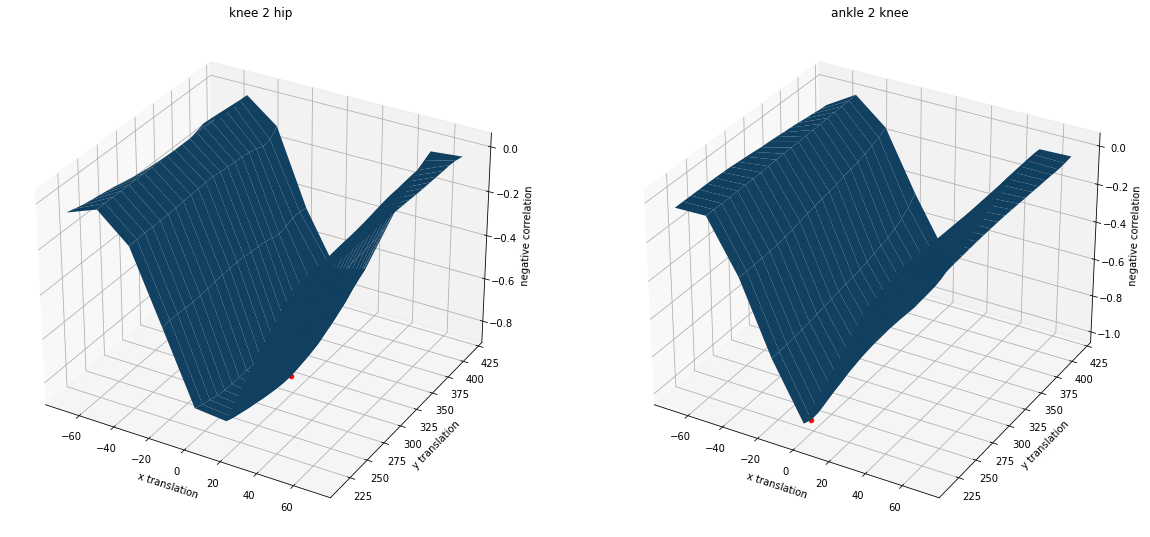

In [6]:
metric_sampling_percentage = 0.2
min_row_overlap = 20
max_row_overlap = 0.5 * hip_image.GetHeight()
column_overlap = 0.2 * hip_image.GetWidth()
dx_step_num = 4
dy_step_num = 10

initializer = Evaluate2DTranslationCorrelation(
    metric_sampling_percentage,
    min_row_overlap,
    max_row_overlap,
    column_overlap,
    dx_step_num,
    dy_step_num,
)

# Get potential starting points for the knee-hip images.
initializer.evaluate(
    fixed_image=sitk.Cast(knee_image, sitk.sitkFloat32),
    moving_image=sitk.Cast(hip_image, sitk.sitkFloat32),
)
plotting_data = [("knee 2 hip", initializer.get_raw_data())]
k2h_candidates = initializer.get_candidates(num_candidates=4, correlation_threshold=0.5)

# Get potential starting points for the ankle-knee images.
initializer.evaluate(
    fixed_image=sitk.Cast(ankle_image, sitk.sitkFloat32),
    moving_image=sitk.Cast(knee_image, sitk.sitkFloat32),
)
plotting_data.append(("ankle 2 knee", initializer.get_raw_data()))
a2k_candidates = initializer.get_candidates(num_candidates=4, correlation_threshold=0.5)

# Plot the similarity metric terrain and mark the minimum with a red sphere.
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 10))
for i, plot_data in enumerate(plotting_data, 1):
    ax = fig.add_subplot(1, 2, i, projection="3d")
    ax.plot_surface(*(plot_data[1]))
    ax.set_xlabel("x translation")
    ax.set_ylabel("y translation")
    ax.set_zlabel("negative correlation")
    ax.set_title(plot_data[0])
    min_index = np.unravel_index((plot_data[1])[2].argmin(), (plot_data[1])[2].shape)
    ax.scatter(
        (plot_data[1])[0][min_index],
        (plot_data[1])[1][min_index],
        (plot_data[1])[2][min_index],
        marker="o",
        color="red",
    );

We will use the hip image coordinate system as the common coordinate system and visualize the results with the transformations corresponding to the best similarity metric values.

knee2hip_correlation: -0.84
ankle2hip_correlation: -0.99


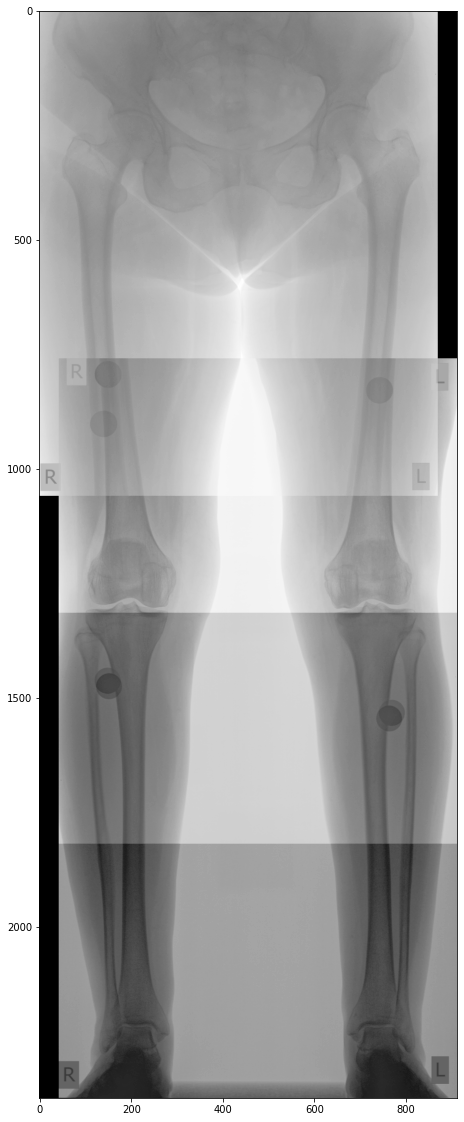

In [7]:
knee2hip_transform = k2h_candidates[0][0]
ankle2knee_transform = a2k_candidates[0][0]
ankle2hip_transform = sitk.CompositeTransform(
    [knee2hip_transform, ankle2knee_transform]
)

image_transform_list = [
    (hip_image, sitk.TranslationTransform(2)),
    (knee_image, knee2hip_transform),
    (ankle_image, ankle2hip_transform),
]
composite_image = composite_images_alpha_blending(
    create_images_in_shared_coordinate_system(image_transform_list)
)

fig = plt.figure(figsize=(20, 20))
plt.imshow(sitk.GetArrayViewFromImage(composite_image),cmap=plt.cm.Greys_r)
#gui.multi_image_display2D([composite_image], figure_size=(4, 8))
print(f"knee2hip_correlation: {k2h_candidates[0][1]:.2f}")
print(f"ankle2hip_correlation: {a2k_candidates[0][1]:.2f}")

## Registration - Exploitation Step
Now that we have a set of good (from a similarity metric standpoint) initial estimates for the transformation we will refine them using standard GradientDescent based registration. The final transformations are those that correspond to the best similarity metric values.

In [8]:
def final_registration(fixed_image, moving_image, initial_mutable_transformations):
    """
    Register the two images using multiple starting transformations.
    Args:
        fixed_image (SimpleITK image): Estimated transformation maps points from this image to the
                                       moving_image.
        moving_image (SimpleITK image): Estimated transformation maps points from the fixed image to
                                        this image.
       initial_mutable_transformations (iterable, list like): Set of initial transformations, these will
                                                              be modified in place.
    """
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsCorrelation()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.2)
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0, numberOfIterations=200
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()

    def reg(transform):
        registration_method.SetInitialTransform(transform)
        registration_method.Execute(fixed_image, moving_image)
        return registration_method.GetMetricValue()

    final_values = [reg(transform) for transform in initial_mutable_transformations]
    return list(zip(initial_mutable_transformations, final_values))

knee2hip_correlation: -0.92
ankle2hip_correlation: -0.99


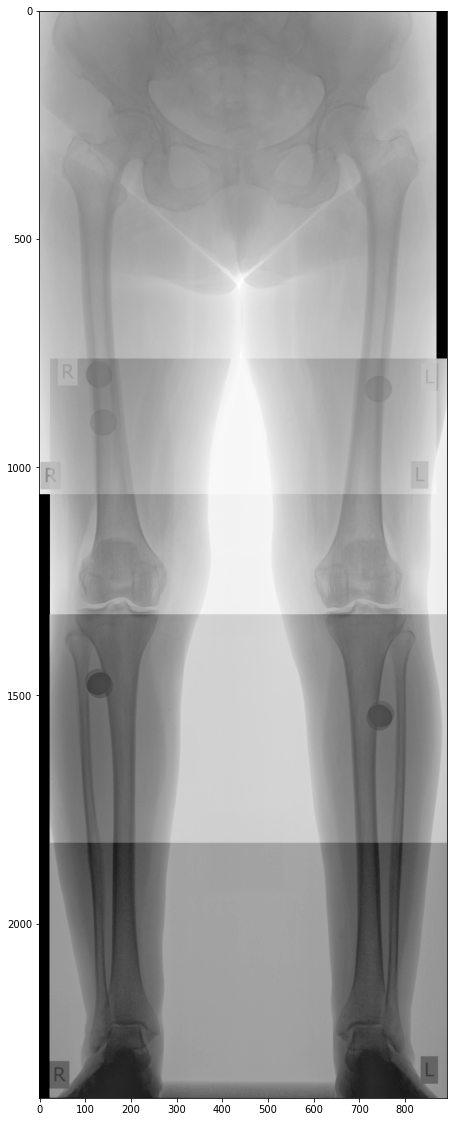

In [9]:
# Copy the initial transformations for use in the final registration
initial_transformation_list_k2h = [
    sitk.TranslationTransform(t) for t, corr in k2h_candidates
]
initial_transformation_list_a2k = [
    sitk.TranslationTransform(t) for t, corr in a2k_candidates
]

# Perform the final registration
k2h_final = final_registration(
    fixed_image=sitk.Cast(knee_image, sitk.sitkFloat32),
    moving_image=sitk.Cast(hip_image, sitk.sitkFloat32),
    initial_mutable_transformations=initial_transformation_list_k2h,
)
a2k_final = final_registration(
    fixed_image=sitk.Cast(ankle_image, sitk.sitkFloat32),
    moving_image=sitk.Cast(knee_image, sitk.sitkFloat32),
    initial_mutable_transformations=initial_transformation_list_a2k,
)

knee2hip = min(k2h_final, key=lambda x: x[1])
knee2hip_transform = knee2hip[0]

ankle2knee = min(a2k_final, key=lambda x: x[1])
ankle2hip_transform = sitk.CompositeTransform([knee2hip_transform, ankle2knee[0]])

image_transform_list = [
    (hip_image, sitk.TranslationTransform(2)),
    (knee_image, knee2hip_transform),
    (ankle_image, ankle2hip_transform),
]
composite_image = composite_images_alpha_blending(
    create_images_in_shared_coordinate_system(image_transform_list)
)

fig = plt.figure(figsize=(20, 20))
plt.imshow(sitk.GetArrayViewFromImage(composite_image),cmap=plt.cm.Greys_r)
print(f"knee2hip_correlation: {knee2hip[1]:.2f}")
print(f"ankle2hip_correlation: {ankle2knee[1]:.2f}")